In [1]:
## Creating a graph from text data

### Loading the text data

In [27]:
import pandas as pd

In [28]:
graph_data_path = '/home/benjamin/Documents/memetracker/Data/graph/'
pickle_data_path = '/home/benjamin/Documents/memetracker/Data/pickle/'
series_name = 'baron_noir'
pickle_file = pickle_data_path+series_name+'_texts'+'.pkl'
vocab_file = pickle_data_path+series_name+'_vocab_bow'+'.pkl'
tfidf_file = pickle_data_path+series_name+'_vocab_tfidf'+'.pkl'

In [29]:
text_data = pd.read_pickle(pickle_file)
vocab_data = pd.read_pickle(vocab_file)
tfidf_data = pd.read_pickle(tfidf_file)

In [30]:
# create the set of most used words
nb_words = 100
word_set = set(tfidf_data.words[0:nb_words])

In [31]:
word_set

{'2016',
 '20h55',
 'ans',
 'après',
 'arestrup',
 'aussi',
 'avant',
 'baron',
 'baronnoir',
 'bien',
 'bon',
 'bonne',
 'bosso',
 'bravo',
 'canal',
 'canalplus',
 'cards',
 'casting',
 'chance',
 'coffret',
 'coffrets',
 'comme',
 'contre',
 'création',
 'demain',
 'demande',
 'deux',
 'diffusée',
 'dit',
 'dray',
 'dunkerque',
 'dvd',
 'déjà',
 'ebenzekri',
 'encore',
 'entre',
 'faire',
 'fait',
 'fiction',
 'follow',
 'fort',
 'france',
 'français',
 'française',
 'françois',
 'février',
 'gagner',
 'hollande',
 'house',
 'houseofcards',
 'ils',
 'jeu',
 'jeudi',
 'julien',
 'kad',
 'kadmerad',
 'loi',
 'lundi',
 'mal',
 'marseille',
 'marseillelefilm',
 'merad',
 'merci',
 'mis',
 'niels',
 'noir',
 'nouvelle',
 'originale',
 'paris',
 'plus',
 'politique',
 'politiques',
 'président',
 'quand',
 'regarder',
 'rickwaert',
 'réalité',
 'saison',
 'serie',
 'seriescanalplus',
 'soir',
 'sort',
 'série',
 'séries',
 'tenter',
 'tirage',
 'top',
 'tournage',
 'tous',
 'tout',
 'trop

### Creating the graph

In [32]:
import networkx as nx
import matplotlib.pyplot as plt

In [33]:
G = nx.Graph()

In [34]:
# Add the nodes
G.add_nodes_from(word_set)

In [35]:
import itertools

In [36]:
# Connect the nodes if they appear in the same text
# the weight is proportional to the number of co-occurences
for text in text_data.text:
    common_words = set(str(text).split())&word_set
    edge_list = list(itertools.combinations(common_words, 2))
    #G.add_edges_from(edge_list)
    for edge in edge_list:
        if G.has_edge(edge[0],edge[1]):
            # we added this one before, just increase the weight by one
            G[edge[0]][edge[1]]['weight'] += 1
        else:
            # new edge. add with weight=1
            G.add_edge(edge[0], edge[1], weight=1)

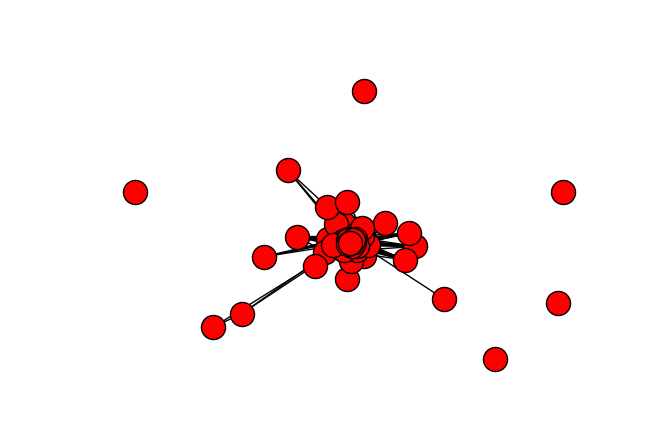

In [37]:
nx.draw_spring(G)
plt.show()

### Community detection

In [38]:
import community

In [39]:
#first compute the best partition
clusterDic = community.best_partition(G)

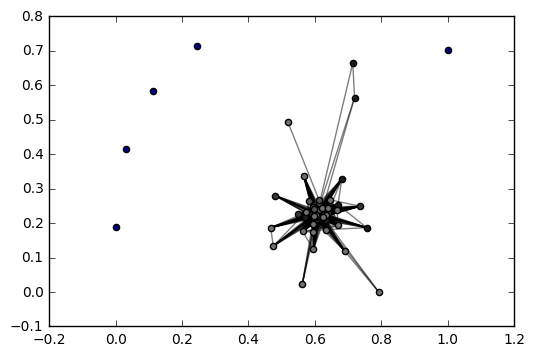

In [40]:
#drawing
partition = clusterDic
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

In [41]:
nx.set_node_attributes(G,'cluster',clusterDic)

### Thresholding the edges

In [42]:
# Extracting the edge information
#sum_weight = 0
#n_edges = 0
#for u,v,a in G.edges(data=True):
#    sum_weight+=a['weight']
#    n_edges+=1
#average_weight = sum_weight*1.0/n_edges

In [43]:
# Node properties: degree and centrality
degreeDic = G.degree(weight='weight')
nx.set_node_attributes(G,'degree',degreeDic)
bcDic = nx.betweenness_centrality(G)
nx.set_node_attributes(G,'bCentrality',bcDic)

In [44]:
# Rescaling edge weights
n1,n2,weights = zip(*G.edges(data='weight'))
edges_id=list(zip(n1,n2))

In [45]:
import numpy as np
print('mean weight: '+str(np.mean(weights))+', max weight: '+str(np.max(weights)))

mean weight: 137.125793771, max weight: 2486


In [46]:
weights_n=weights/np.max(weights)
weights_n_dic=dict(zip(edges_id,weights_n)) 
nx.set_edge_attributes(G,'weight',weights_n_dic)

In [47]:
#nx.edge_betweenness_centrality(G, normalized=False)

In [48]:
# Sparsify the graph if the weight are too small
average_weight = np.mean(weights)/np.max(weights)
for u,v,a in G.edges(data=True):
    if a['weight']<average_weight*5:
        G.remove_edge(u,v)

In [49]:
# Write the graph to a json file
from networkx.readwrite import json_graph
datag = json_graph.node_link_data(G)
import json
s = json.dumps(datag)
datag['links'] = [
        {
            'source': datag['nodes'][link['source']]['id'],
            'target': datag['nodes'][link['target']]['id'],
            'weight': link['weight']
        }
        for link in datag['links']]
s = json.dumps(datag)
with open("viz/graph.json", "w") as f:
    f.write(s)

In [25]:
G.edges(data='weight')

[('série', 'bien', 0.38778747026169708),
 ('série', 'tout', 0.39175257731958762),
 ('série', 'est', 0.8977002379064235),
 ('série', 'nouvelle', 0.55987311657414751),
 ('série', 'aussi', 0.44607454401268837),
 ('série', 'fait', 0.39849325931800161),
 ('série', 'politique', 0.98572561459159402),
 ('série', 'plus', 0.55154639175257736),
 ('série', 'très', 0.40325138778747027),
 ('série', 'faire', 0.34892942109436953),
 ('série', 'il', 0.49960348929421095),
 ('série', 'noir', 0.40007930214115783),
 ('série', 'comme', 0.42030134813639969),
 ('série', 'un', 0.84377478191911182),
 ('série', 'deux', 0.37232355273592388),
 ('série', 'entre', 0.36915146708961144),
 ('bien', 'tout', 0.35646312450436163),
 ('bien', 'est', 0.52854877081681206),
 ('bien', 'fait', 0.35567010309278352),
 ('bien', 'plus', 0.43893735130848532),
 ('bien', 'il', 0.40999206978588421),
 ('bien', 'comme', 0.32870737509912767),
 ('bien', 'un', 0.51784298176050758),
 ('tout', 'est', 0.61062648691514676),
 ('tout', 'fait', 0.39

In [ ]:
clusterDic